In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stockdata/MSFT-1.csv


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    !pip install -q -U tensorflow-addons
    !pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [3]:
data = pd.read_csv("/kaggle/input/stockdata/MSFT-1.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,11/7/2016,59.779999,60.520000,59.779999,60.419998,55.902321,31664800
1,11/8/2016,60.549999,60.779999,60.150002,60.470001,55.948589,22935400
2,11/9/2016,60.000000,60.590000,59.200001,60.169998,55.671009,49632500
3,11/10/2016,60.480000,60.490002,57.630001,58.700001,54.310928,57822400
4,11/11/2016,58.230000,59.119999,58.009998,59.020000,54.607002,38767800


In [4]:
data.drop('Adj Close', axis = 1, inplace = True)
data['Date'] = pd.to_datetime(data.Date,format='%m/%d/%Y')
data.index = data['Date']
data.drop('Date', axis = 1, inplace = True)
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,59.779999,60.520000,59.779999,60.419998,31664800
2016-11-08,60.549999,60.779999,60.150002,60.470001,22935400
2016-11-09,60.000000,60.590000,59.200001,60.169998,49632500
2016-11-10,60.480000,60.490002,57.630001,58.700001,57822400
2016-11-11,58.230000,59.119999,58.009998,59.020000,38767800


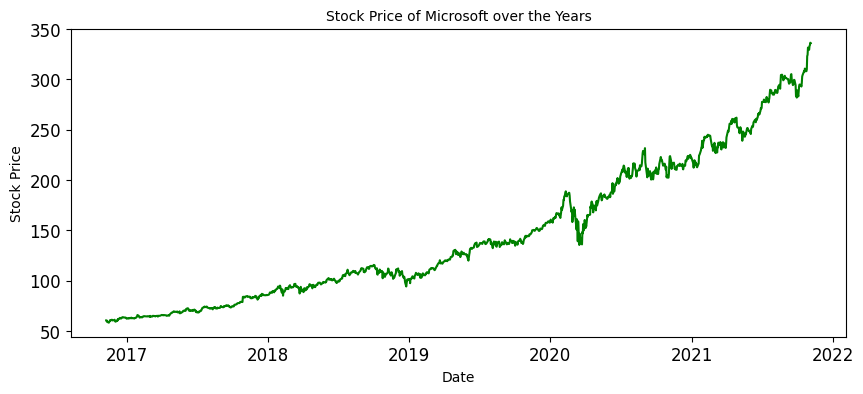

In [5]:
plt.figure(figsize=(10,4))
plt.plot(data['Close'], label='Close Price history',color='g')
plt.xlabel('Date',size=10)
plt.ylabel('Stock Price',size=10)
plt.title('Stock Price of Microsoft over the Years',size=10)
plt.show()

In [53]:
from sklearn.preprocessing import MinMaxScaler
def Normalize(data):
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(data), scaler

**Use 50 days data to predict next 10 days**

In [54]:
def windows(sequence, step_in, step_out):
    x, y = [], []
    for i in range(len(sequence)):
        end_i = i + step_in
        out_i = end_i + step_out
        if out_i > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_i, :], sequence[end_i:out_i, :]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

def creat_model(step_in, step_out):
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(step_in,1)))
    model.add(LSTM(units=50))
    model.add(Dense(step_out))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [56]:
def prepare_training(data, step_in, step_out):
    data, scaler = Normalize(data)
    x_train, y_train = windows(data, step_in, step_out)
    return data, scaler, x_train, y_train

In [57]:
step_in, step_out = 50, 10 
epochs = 5

data_Close = data['Close'].values
data_Close = data_Close.reshape(-1, 1)

data_Close, scaler, x_train, y_train = prepare_training(data_Close, step_in, step_out)

In [58]:
print(x_train.shape)

(1200, 50, 1)


In [25]:
model = creat_model(step_in, step_out)

In [59]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=1, verbose=2)

Epoch 1/5
1200/1200 - 30s - loss: 6.7224e-04 - 30s/epoch - 25ms/step
Epoch 2/5
1200/1200 - 30s - loss: 8.0511e-04 - 30s/epoch - 25ms/step
Epoch 3/5
1200/1200 - 30s - loss: 6.8929e-04 - 30s/epoch - 25ms/step
Epoch 4/5
1200/1200 - 31s - loss: 6.3501e-04 - 31s/epoch - 25ms/step
Epoch 5/5
1200/1200 - 31s - loss: 6.2091e-04 - 31s/epoch - 25ms/step


In [60]:
print(data_Close)

[[0.00826387]
 [0.00844353]
 [0.00736562]
 ...
 [0.99123311]
 [1.        ]
 [0.99863465]]


In [61]:
def prepare_prediction(data):
    x_pred = np.array(data[-50:])
    x_pred = np.reshape(x_pred, (1,x_pred.shape[0],x_pred.shape[1]))
    print(x_pred.shape)
    return x_pred

In [62]:
x_pred = prepare_prediction(data_Close)

(1, 50, 1)


In [69]:
def prediction(model, scaler, data):
    y_pred = model.predict(data)
    y_pred = scaler.inverse_transform(y_pred)
    print(y_pred)
    return y_pred

In [70]:
y_pred_close = prediction(model, scaler, x_pred)

1/1 [==============================] - 0s 29ms/step
[[324.15823 323.63528 325.78668 326.38065 326.8675  329.47913 330.26343
  330.95282 326.42862 332.4776 ]]
